In [1]:
import skimage.measure as msr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd

In [2]:
# import sys
# sys.path.append("..")

In [3]:
# Importing class from wmark.py
from wmark import WaterMark

In [4]:
import glob
import os
from pathlib import Path

In [5]:
# Source Directory
srcFolder = 'TestSet/'
# Source Path
srcPth = Path(srcFolder).resolve()

In [6]:
# All TIF files in the src_path are now imgs
imgs = srcPth.glob('*.tif')

In [7]:
# Creating empty DataFrames that will fill up during the loop
dataframeFinalPSNR = pd.DataFrame()
dataframeFinalSSIM = pd.DataFrame()

for img in imgs:
    
    imgOriginal = WaterMark.imread(img)

    # Attributes: 
        # img - required
        # seed - required
        # max_impact (logarithmic scale) - optional; default = 0.75
        # max_impact (logarithmic scale) - optional; default = 4
        # steps - optional; default = 25
    dataframeTemp = WaterMark.impactFactorMetric(imgOriginal, seed = 5)
    
    # Creating temporary DataFrames
    dataframeIF = dataframeTemp['Impact Factor']
    dataframePSNR = dataframeTemp['PSNR']
    dataframeSSIM = dataframeTemp['SSIM']
    
    # Creating final DataFrames (separated for PSNR and SSIM)
    dataframeFinalPSNR = pd.concat([dataframeFinalPSNR, dataframePSNR], axis= 1)
    dataframeFinalSSIM = pd.concat([dataframeFinalSSIM, dataframeSSIM], axis= 1)
    
    #Print a dot after looping through each image (to keep track of progress)
    print('.')

/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/zgebac/miniconda3/envs/img-proc/lib/python3.7/site-packages/skimage/measure/simple_metrics.py:144: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


.
.
.
.
.


In [8]:
# Adding Impact Factor values to PSNR/SSIM DataFrames
dataframeFinalIFPSNR = pd.concat([dataframeIF, dataframeFinalPSNR], axis= 1)
dataframeFinalIFSSIM = pd.concat([dataframeIF, dataframeFinalSSIM], axis= 1)

In [9]:
# Making Impact Factor index
dataframeFinalIFPSNRIndex = dataframeFinalIFPSNR.set_index('Impact Factor')
dataframeFinalIFSSIMIndex = dataframeFinalIFSSIM.set_index('Impact Factor')

In [10]:
dataframeFinalIFPSNRIndex

,PSNR,PSNR,PSNR,PSNR,PSNR
Impact Factor,,,,,
5.623413,inf,inf,inf,inf,inf
7.680981,inf,inf,inf,inf,inf
10.491397,inf,inf,inf,inf,inf
14.330126,inf,inf,inf,inf,102.316203
19.573418,inf,88.424542,inf,inf,86.032314
26.735194,97.197369,74.695046,89.824219,87.581333,73.568486
36.517413,80.343397,66.793781,75.370151,73.789878,66.259382
49.878877,70.370366,62.243420,67.256229,66.385836,62.013040
68.129207,64.671826,59.459842,62.619482,62.121716,59.318135


In [11]:
dataframeFinalIFSSIMIndex

,SSIM,SSIM,SSIM,SSIM,SSIM
Impact Factor,,,,,
5.623413,1.000000,1.000000,1.000000,1.000000,1.000000
7.680981,1.000000,1.000000,1.000000,1.000000,1.000000
10.491397,1.000000,1.000000,1.000000,1.000000,1.000000
14.330126,1.000000,1.000000,1.000000,1.000000,1.000000
19.573418,1.000000,1.000000,1.000000,1.000000,0.999999
26.735194,1.000000,0.999998,1.000000,0.999999,0.999991
36.517413,0.999995,0.999984,0.999987,0.999984,0.999941
49.878877,0.999942,0.999951,0.999905,0.999903,0.999810
68.129207,0.999743,0.999897,0.999688,0.999704,0.999578


In [12]:
# Creating DataFrames with mean PSNR/SSIM values
dataframeFinalPSNRMean = dataframeFinalIFPSNRIndex.mean(axis = 1)
dataframeFinalSSIMMean = dataframeFinalIFSSIMIndex.mean(axis = 1)

In [13]:
dataframeFinalPSNRMean

Impact Factor
5.623413              inf
7.680981              inf
10.491397             inf
14.330126             inf
19.573418             inf
26.735194       84.573291
36.517413       72.511318
49.878877       65.653778
68.129207       61.638200
93.057204       58.953593
127.106180      56.614941
173.613436      54.191909
237.137371      51.643285
323.904265      49.032293
442.418555      46.381414
604.296390      43.708034
825.404185      41.023884
1127.413766     37.788897
1539.926526     33.366278
2103.374801     27.889524
2872.984833     22.946464
3924.189758     19.131878
5360.023165     16.182416
7321.217908     13.759209
10000.000000    11.768883
dtype: float64

In [14]:
dataframeFinalSSIMMean

Impact Factor
5.623413        1.000000
7.680981        1.000000
10.491397       1.000000
14.330126       1.000000
19.573418       1.000000
26.735194       0.999997
36.517413       0.999978
49.878877       0.999902
68.129207       0.999722
93.057204       0.999407
127.106180      0.998873
173.613436      0.997923
237.137371      0.996201
323.904265      0.993196
442.418555      0.988146
604.296390      0.980135
825.404185      0.968427
1127.413766     0.952775
1539.926526     0.933329
2103.374801     0.910070
2872.984833     0.880450
3924.189758     0.841253
5360.023165     0.789284
7321.217908     0.720329
10000.000000    0.635081
dtype: float64

Text(0, 88.5, 'For low Impact factor values, PSNR values are very high, but dropping down rapidly.\nWith larger Impact Factor values, PSNR values are still dropping, but not as rapidly.')

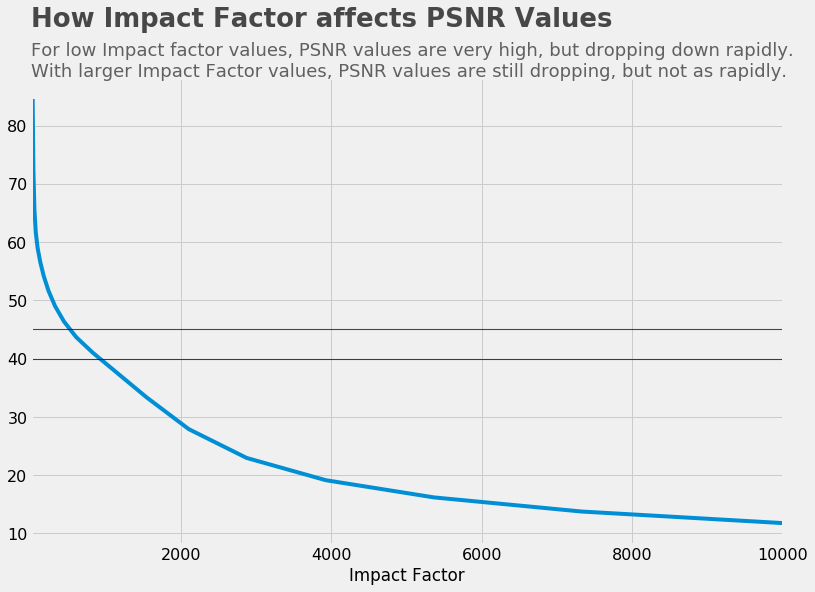

In [25]:
# https://www.dataquest.io/blog/making-538-plots/

style.use('fivethirtyeight')

# Creating Impact Factor / PSNR graph
fteGraph1 = dataframeFinalPSNRMean.plot(x = 'Impact Factor', y = 'PSNR', figsize = (12, 8))
# Setting rules for labeling axes
fteGraph1.tick_params(axis = 'both', which = 'major', labelsize = 16)

# Creating different lines accross the graph (can be used for important slices of results)
fteGraph1.axhline(y = 40, color = 'black', linewidth = 1.1, alpha = .7)
fteGraph1.axhline(y = 45, color = 'black', linewidth = 1.1, alpha = .7)

# Setting visibility of X-label
fteGraph1.xaxis.label.set_visible(True)


# Title

# Y value is continuous to values on Y-axis. For instance, 
# if the maximum value is 60, the text can begin at 61.

# Alpha indicates text opacity

fteGraph1.text(x = 0, y = 97, s = "How Impact Factor affects PSNR Values",
               fontsize = 26, weight = 'bold', alpha = .7)

# Subtitle
fteGraph1.text(x = 0, y = 88.5,
               s = "For low Impact factor values, PSNR values are very high, but dropping down rapidly.\nWith larger Impact Factor values, PSNR values are still dropping, but not as rapidly.",
              fontsize = 18, alpha = .6)

Text(0, 1.02, 'For low Impact Factor values, SSIM values stay close do 1,\nbut keep dropping towards zero with larger Impact Factor values.')

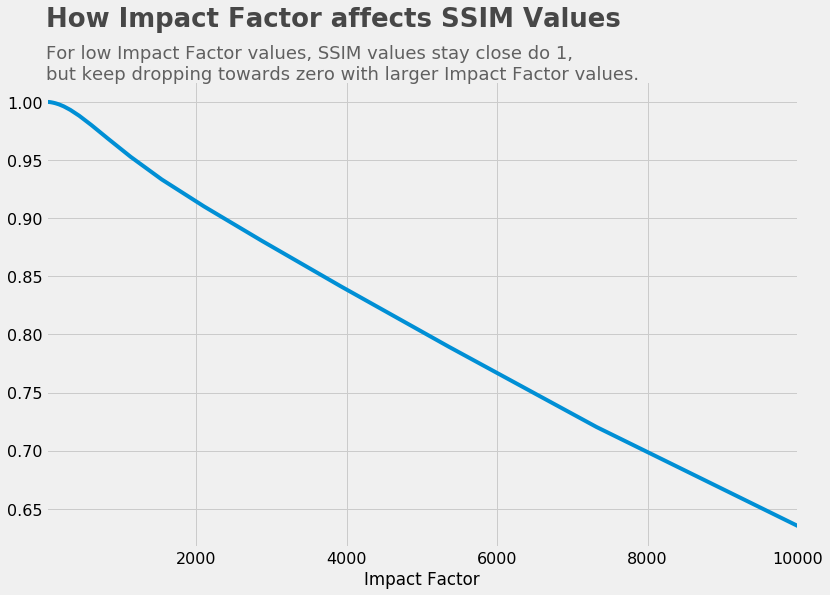

In [26]:
fteGraph2 = dataframeFinalSSIMMean.plot(x = 'Impact Factor', y = 'SSIM', figsize = (12, 8))
fteGraph2.tick_params(axis = 'both', which = 'major', labelsize = 16)

# Creating different lines accross the graph (can be used for important slices)
# fte_graph_2.axhline(y = 0.5, color = 'black', linewidth = 1.1, alpha = .7)
# fte_graph_2.axhline(y = 1, color = 'black', linewidth = 1.1, alpha = .7)

# Setting visibility of X-label
fteGraph2.xaxis.label.set_visible(True)

# Title
fteGraph2.text(x = 0, y = 1.065, s = "How Impact Factor affects SSIM Values",
               fontsize = 26, weight = 'bold', alpha = .7)

# Subtitle
fteGraph2.text(x = 0, y = 1.02,
               s = "For low Impact Factor values, SSIM values stay close do 1,\nbut keep dropping towards zero with larger Impact Factor values.",
              fontsize = 18, alpha = .6)

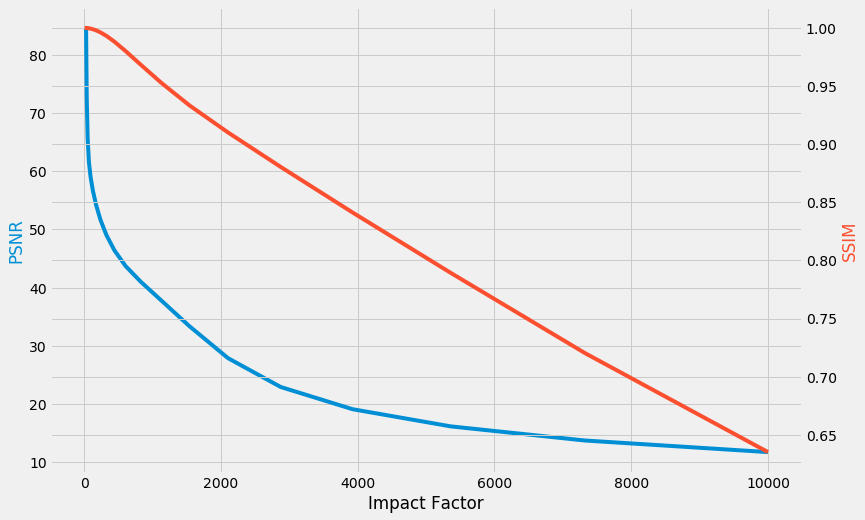

In [27]:
# Colors: https://github.com/matplotlib/matplotlib/blob/38be7aeaaac3691560aeadafe46722dda427ef47/lib/matplotlib/mpl-data/stylelib/fivethirtyeight.mplstyle

plt.style.use('fivethirtyeight')

# Creating graph
fig, ax1 = plt.subplots(figsize=(12,8))

# Setting X-axis and first Y-axis
ax1.set_xlabel('Impact Factor')
ax1.set_ylabel('PSNR', color = '#008fd5')

# Creating a second Y-axis that shares the same X-axis
ax2 = ax1.twinx()  
ax2.set_ylabel('SSIM', color = '#fc4f30')

# Show grid
ax1.grid(True)
ax2.grid(True)

# Setting different colors for each variable
ax1.plot(dataframeFinalPSNRMean, color = '#008fd5')
ax2.plot(dataframeFinalSSIMMean, color = '#fc4f30')